In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import sys
from pathlib import Path

sys.path.insert(0, Path("").resolve().parent.parent.as_posix())
from utils import base_util, dataset

# Residual Network

1. 当`use_1x1conv=False`时，应用ReLU非线性函数之前，将输入添加到输出。
2. 当`use_1x1conv=True`时，添加通过$1 \times 1$卷积调整通道和分辨率。

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](../img/resnet-block.svg)


## [**Residual Block**]

In [2]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**Residual Network**]

In [5]:
# 和GoogLeNet类似，使用步幅为2的残差块在每个模块之间的通道数翻倍，同时分辨率减半。

b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [6]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
# 每个模块有4个卷积层(不包括恒等映射的1 × 1卷积层)。加上第一个7 × 7卷积层和最后一个全连接层,共有18层。（Resnet-18模型）
# 152层的ResNet-152模型

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


train loss 0.000, train acc 0.990, test acc 0.876
3910.6 examples/sec on cuda:0


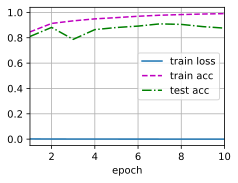

In [25]:
lr, num_epochs, batch_size = 0.05, 10, 256
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
train_iter, test_iter = dataset.FashionMNISTDataset(root=root, resize=96).get_dataloader(batch_size)
base_util.train(net, train_iter, test_iter, nn.CrossEntropyLoss(), num_epochs, torch.optim.SGD(net.parameters(), lr=lr))

# DenseNet

![稠密连接。](../img/densenet.svg)
稠密网络主要由2部分构成:稠密块(dense block)和过渡层(transition layer)。前者定义如何连接输入和输出,而后者则控制通道数量,使其不会太复杂。

## [**Dense Block**]

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(), nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**Transition Layer**]

In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2),
    )

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**Dense Model**]

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [8]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [9]:
net = nn.Sequential(
    b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(num_channels, 10)
)

train loss 0.001, train acc 0.951, test acc 0.858
2961.9 examples/sec on cuda:0


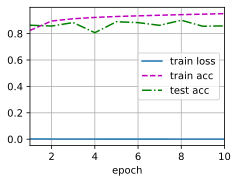

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
train_iter, test_iter = dataset.FashionMNISTDataset(root=root, resize=96).get_dataloader(batch_size)
base_util.train(net, train_iter, test_iter, nn.CrossEntropyLoss(), num_epochs, torch.optim.SGD(net.parameters(), lr=lr))